In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from matplotlib.colors import LogNorm


In [9]:
#checking the vaildity of the source plane map
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from lenstronomy.LensModel.convergence_integrals import deflection_from_kappa_grid 

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, 679), np.linspace(0, size, 679))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)




81 1104 1144


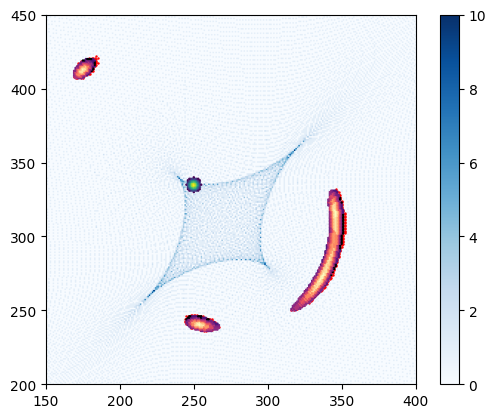

In [71]:
array_test2 = np.zeros([678,678])

img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
# integer search method
for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test2[yceil,xceil] += 1 #data_img[i,j]*ydec*xdec
        #array_test2[yceil,xfloor] += 1 #data_img[i,j]*ydec*(1-xdec)
        #array_test2[yfloor,xceil] += 1 #data_img[i,j]*(1-ydec)*xdec
        if i%3==0 and j%3==0:
            array_test2[yfloor,xfloor] += 1 #data_img[i,j]*(1-ydec)*(1-xdec)
        img_coord_in_src_coord[yfloor][xfloor].append([i,j])
        #img_coord_in_src_coord[yfloor][xceil].append([i,j])
        #img_coord_in_src_coord[yceil][xfloor].append([i,j])
        #img_coord_in_src_coord[yceil][xceil].append([i,j])
       

# gaussian circle
mean = np.array([250, 335])  # Center of the Gaussian circle
sigma_x, sigma_y = 3, 3  # Standard deviations along the x and y axis
cov = np.diag([sigma_x**2, sigma_y**2])  # Covariance matrix
radius = 5
# Step 2: Create a grid of (x,y) coordinates
x = np.linspace(0, size-1, size)
y = np.linspace(0, size-1, size)
X, Y = np.meshgrid(x, y)
distance = np.sqrt((X-mean[0])**2 + (Y-mean[1])**2)
# Step 3: Calculate the Gaussian values for each point on the grid
d = np.dstack([X, Y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
within_radius = distance <= radius
for i in range(0, size):
    for j in range(0, size):
        if not within_radius[i,j]:
            gaussian_circle[i,j] = 0
circle_coords = np.argwhere(gaussian_circle > 0) #(y,x)

'''#normal circle
radius = 5
center = (250, 330)  

x, y = np.meshgrid(range(size), range(size))
circle = ((x - center[0])**2 + (y - center[1])**2) <= radius**2
circle_coords = np.argwhere(circle > 0) #(y,x)'''

scatterx, scattery = [], []
n=0
intensity = []
for (i,j) in circle_coords:
    intensity.append(gaussian_circle[i,j])
    
plt.scatter(circle_coords[:,1],circle_coords[:,0],s=0.5, c=intensity)

for (i,j) in circle_coords:
    
    for point in img_coord_in_src_coord[i][j]:
        n+=1
        scatterx.append(point[1])
        scattery.append(point[0])
        
plt.scatter(scatterx,scattery,s=0.5, c='r')

m=0
scatterx_1, scattery_1, intensity_img = [], [], []
#specific method for perfect circle
for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j]
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        dist = np.sqrt((ycoord-mean[1])**2+(xcoord-mean[0])**2)
        if dist <= radius:
            scatterx_1.append(j)
            scattery_1.append(i)
            intensity_img.append(gaussian_circle[ceil(ycoord),ceil(xcoord)]) # need to be fixed
            m+=1
            
            
plt.scatter(scatterx_1,scattery_1,s=0.5, c=intensity_img, cmap='magma')

'''plt.scatter(mean[0],mean[1],c='r', s=1)
for point in img_coord_in_src_coord[mean[1]][mean[0]]:
    plt.scatter(point[1],point[0],c='r', s=1)'''



plt.imshow(array_test2, cmap='Blues',vmax=10)
plt.xlim(150,400)
plt.ylim(200,450)
plt.colorbar()
print(len(circle_coords), n, m)


Magnification: [1.6, 3.6, 1.6, 1.2]
Number of pixels: [8, 18, 8, 6]


(150.0, 450.0)

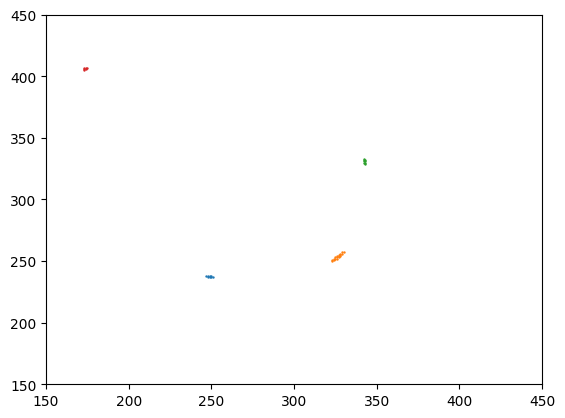

In [61]:
#magnification
from sklearn.cluster import DBSCAN
coordinates = []
for i in range(0, len(scatterx_1)):
    coordinates.append([scatterx_1[i], scattery_1[i]])
coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=5).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)

m=[]
for i in range(0, len(images)):
    mag = len(images[i])/len(circle_coords)
    m.append(mag)
print(f'Magnification: {m}')
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.xlim(150,450)
plt.ylim(150,450)

In [ ]:
#finding suitable eps and min_samples
eps_values = np.linspace(3, 50.5, 96)  # Smaller values make the algorithm more sensitive to distance
min_samples_values = np.arange(5, 100)  # Adjust based on your data's density
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        labels = dbscan.labels_
        
        # Count the number of clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        pixels = sum(len(coordinates[labels == i]) for i in range(0, n_clusters))
        if (n_clusters == 4 and pixels > 1063):
            print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}")
        

In [108]:
from scipy.ndimage import distance_transform_edt as distance
'''# square ugly source
source_x = np.linspace(295, 304, 10)
source_y = np.linspace(315, 324, 10)
source_x, source_y = np.meshgrid(source_x, source_y)
source_x_1d = source_x.ravel()
source_y_1d = source_y.ravel()
# circle source
size = 680
radius = 7
center = [300,320]
# Create a 2D grid of points
x, y = np.meshgrid(np.arange(size), np.arange(size))

# Calculate the distance of each point from the center of the array
distances = distance((x - center[0])**2 + (y - center[1])**2)

# Create a binary mask where points inside the circle are 1 and points outside the circle are 0 given the center coordinates
circle = (distances < radius).astype(int)
circle_coords = np.argwhere(circle == 1)'''





'# square ugly source\nsource_x = np.linspace(295, 304, 10)\nsource_y = np.linspace(315, 324, 10)\nsource_x, source_y = np.meshgrid(source_x, source_y)\nsource_x_1d = source_x.ravel()\nsource_y_1d = source_y.ravel()\n# circle source\nsize = 680\nradius = 7\ncenter = [300,320]\n# Create a 2D grid of points\nx, y = np.meshgrid(np.arange(size), np.arange(size))\n\n# Calculate the distance of each point from the center of the array\ndistances = distance((x - center[0])**2 + (y - center[1])**2)\n\n# Create a binary mask where points inside the circle are 1 and points outside the circle are 0 given the center coordinates\ncircle = (distances < radius).astype(int)\ncircle_coords = np.argwhere(circle == 1)'

In [36]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# solve by fansy package
solver = LensEquationSolver(lensModel)
image_x = []
image_y = []
intensity = []
for i in range(0, len(circle_coords)):
    x = circle_coords[i,1]
    y = circle_coords[i,0]
    theta_x, theta_y = solver.image_position_analytical(x=x, y=y, kwargs_lens=kwargs_lens)
    image_x.append(theta_x)
    image_y.append(theta_y)
    intensity.extend([gaussian_circle[y,x]]*len(theta_x))
    

'''image_x_sq = []
image_y_sq = []
for i in range(0, 10):
    for j in range(0, 10):
        x = source_x[i,j]
        y = source_y[i,j]
        theta_x, theta_y = solver.image_position_analytical(x=x, y=y, kwargs_lens=kwargs_lens)
        image_x_sq.append(theta_x)
        image_y_sq.append(theta_y)'''
        


# make image_x in a 1d array
image_x_1d = np.concatenate(image_x)
image_y_1d = np.concatenate(image_y)
image = np.array(np.meshgrid(image_x_1d, image_y_1d))

#using scatter plot for all maybe?
circle_graph = gaussian_circle * 10
intensity = np.array(intensity)
intensity_graph = intensity / 2

 
graph = circle_graph + array_test2

'''plt.imshow(graph, cmap='Blues')
plt.scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph)

plt.xlim(150,450)
plt.ylim(150,450)

#calculate the magnification'''


"plt.imshow(graph, cmap='Blues')\nplt.scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph)\n\nplt.xlim(150,450)\nplt.ylim(150,450)\n\n#calculate the magnification"

(150.0, 450.0)

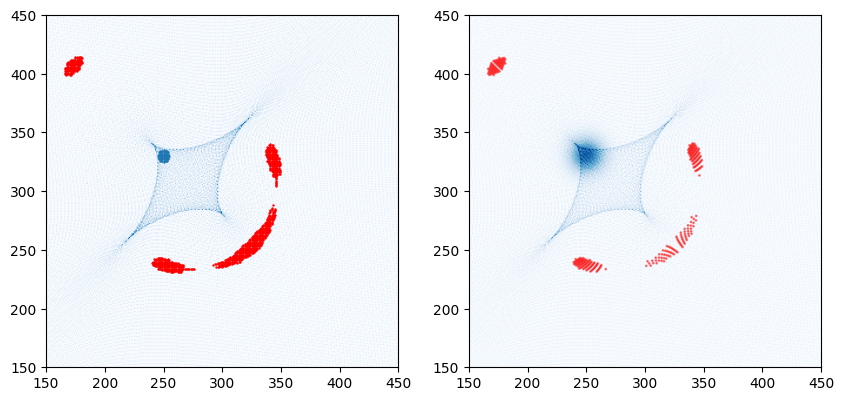

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(array_test2, cmap='Blues',vmax=10)
ax[0].scatter(circle_coords[:,1],circle_coords[:,0],s=0.5)
for (i,j) in circle_coords:
    for point in img_coord_in_src_coord[i][j]:
        ax[0].scatter(point[1],point[0],s=0.5, c='red')

#ax[0].gca().invert_yaxis()
ax[0].set_xlim(150,450)
ax[0].set_ylim(150,450)

ax[1].scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph) 
graph = circle_graph + array_test2

ax[1].imshow(graph, cmap='Blues')

#ax[1].gca().invert_yaxis()
ax[1].set_xlim(150,450)
ax[1].set_ylim(150,450)

(0.0, 600.0)

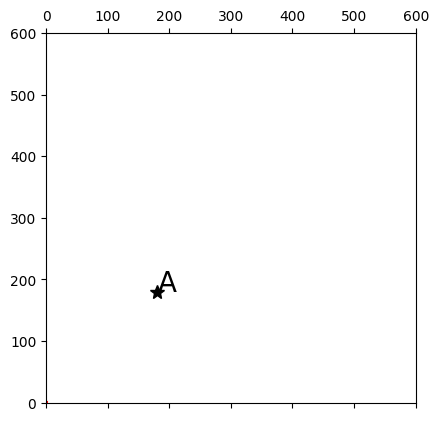

In [147]:
from lenstronomy.Plots import lens_plot

f, ax = plt.subplots()
src_x, src_y = 180,180

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens,numPix=5000, deltaPix=0.25, sourcePos_x=src_x, sourcePos_y=src_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
# make the plot to have 679x679 pixels
plt.xlim(0,600)
plt.ylim(0,600)

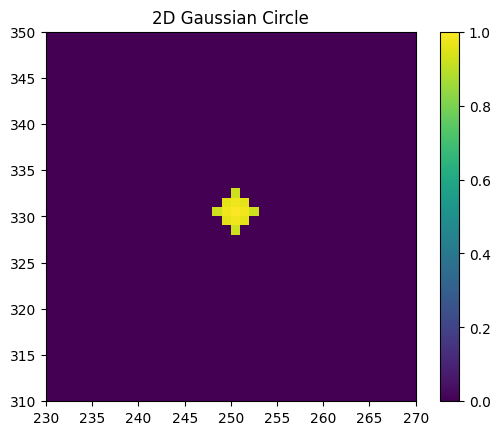

In [35]:
mean = np.array([250, 330])  # Center of the Gaussian circle
sigma_x, sigma_y = 5, 5  # Standard deviations along the x and y axis
cov = np.diag([sigma_x**2, sigma_y**2])  # Covariance matrix
radius = 2
# Step 2: Create a grid of (x,y) coordinates
x = np.linspace(0, size-1, size)
y = np.linspace(0, size-1, size)
X, Y = np.meshgrid(x, y)
distance = np.sqrt((X-mean[0])**2 + (Y-mean[1])**2)
# Step 3: Calculate the Gaussian values for each point on the grid
d = np.dstack([X, Y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
within_radius = distance <= radius
for i in range(0, size):
    for j in range(0, size):
        if not within_radius[i,j]:
            gaussian_circle[i,j] = 0
# Step 4: Plot the Gaussian Circle
plt.imshow(gaussian_circle, extent=(0, size, size, 0), cmap='viridis')
plt.colorbar()
plt.xlim(230,270)
plt.ylim(310,350)
plt.title('2D Gaussian Circle')
plt.show()